<a href="https://colab.research.google.com/github/srJboca/segmentacion/blob/main/EN/4.%20Prediction%20using%20Data%20Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Late Payment Prediction with PCA

## Introduction

This notebook will guide you through building a model to predict 'Mora' (payment default) for customers. We will explore the use of Principal Component Analysis (PCA) for dimensionality reduction before training a binary classifier.

**Key Points of the Tutorial:**
1.  Preparing data for prediction.
2.  Applying PCA to reduce the dimensionality of the feature set.
3.  Training and evaluating a binary classification model using the principal components.
4.  A method for estimating the importance of the original features after applying PCA.

This iterative approach is common in the development of machine learning models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Downloading and Loading the Preprocessed DataFrame

We will use the `df_analisis.parquet` file.

In [2]:
!wget -N https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
df_analysis = pd.read_parquet('df_analisis.parquet')

--2025-06-13 14:12:16--  https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet [following]
--2025-06-13 14:12:17--  https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75105565 (72M) [application/octet-stream]
Saving to: ‘df_analisis.parquet’

df_analisis.parquet 100%[===================>]  71.63M  96.6MB/s    in 0.7s    

Last-modified header missing -- 

## 2. Quick Data Review
Let's recall the structure of the `df_analysis` DataFrame.

In [3]:
print("--- First 5 rows of df_analysis ---")
print(df_analysis.head())
print("\n--- Information of df_analysis ---")
df_analysis.info()

--- First 5 rows of df_analysis ---
                      Numero de factura                    Numero de contrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
1  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
2  6848b692-4212-4738-a35c-1f8c0d383e3d  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   

  Fecha de Emision  Consumo (m3) Fecha de Pago Oportuno Fecha de Lectura  \
0       2021-01-06         11.51             2021-01-19       2020-12-28   
1       2021-01-06         11.51             2021-01-19       2020-12-28   
2       2021-03-02         10.26             2021-03-17       2021-02-20   
3       2021-04-01         14.96             2021-04-11       2021-03-27   
4       2021-05-10         14.89             2021-05-21       2021-05-05   

  Fecha de Suspensio

In [4]:
df_filtered = df_analysis[[
    'Numero de factura',
    'Consumo (m3)',
    'Estrato',
    'Precio m3 (COP)',
    'Dias_Emision_PagoOportuno',
    'Dias_Lectura_Emision',
    'Dias_PagoOportuno_PagoReal',
    'Mora'
]].copy()

# Check the first few rows and info of the filtered dataframe
print("\n--- First 5 rows of the filtered DataFrame ---")
print(df_filtered.head())
print("\n--- Information of the filtered DataFrame ---")
df_filtered.info()


--- First 5 rows of the filtered DataFrame ---
                      Numero de factura  Consumo (m3)    Estrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706         11.51  Estrato 1   
1  886199bb-77c8-43e2-86a0-a53348fa2706         11.51  Estrato 1   
2  6848b692-4212-4738-a35c-1f8c0d383e3d         10.26  Estrato 1   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf         14.96  Estrato 1   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6         14.89  Estrato 1   

   Precio m3 (COP)  Dias_Emision_PagoOportuno  Dias_Lectura_Emision  \
0              588                         13                     9   
1              588                         13                     9   
2              588                         15                    10   
3              637                         10                     5   
4              637                         11                     5   

   Dias_PagoOportuno_PagoReal  Mora  
0                          -4     0  
1                          -4     0  
2 

In [5]:
# Convert 'Estrato' to numeric (ordinal)

if df_filtered['Estrato'].dtype == 'object' or isinstance(df_filtered['Estrato'].dtype, pd.CategoricalDtype):
    df_filtered['Stratum_Num'] = df_filtered['Estrato'].str.replace('Estrato ', '', regex=False).astype(int)
else:
    df_filtered['Stratum_Num'] = df_filtered['Estrato'].astype(int)

features_for_pca = [
    'Consumo (m3)',
    'Stratum_Num',
    'Precio m3 (COP)',
    'Dias_Emision_PagoOportuno',
    'Dias_Lectura_Emision',
    'Dias_PagoOportuno_PagoReal',
]
X = df_filtered[features_for_pca].copy()

print(f"Shape before dropna: {X.shape}")
X.dropna(inplace=True) # Remove rows with NaNs in these features
print(f"Shape after dropna: {X.shape}")

print("\nMissing values after dropna:")
print(X.isnull().sum())

Shape before dropna: (2400000, 6)
Shape after dropna: (2400000, 6)

Missing values after dropna:
Consumo (m3)                  0
Stratum_Num                   0
Precio m3 (COP)               0
Dias_Emision_PagoOportuno     0
Dias_Lectura_Emision          0
Dias_PagoOportuno_PagoReal    0
dtype: int64


### 3. Feature Scaling
PCA is sensitive to the scale of the features. Therefore, we will standardize the data.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("--- Scaled data (first 5 rows) ---")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

--- Scaled data (first 5 rows) ---
   Consumo (m3)  Stratum_Num  Precio m3 (COP)  Dias_Emision_PagoOportuno  \
0     -0.228758    -1.173305        -1.285281                   0.293913   
1     -0.228758    -1.173305        -1.285281                   0.293913   
2     -0.517315    -1.173305        -1.285281                   1.464782   
3      0.567660    -1.173305        -1.196012                  -1.462391   
4      0.551500    -1.173305        -1.196012                  -0.876957   

   Dias_Lectura_Emision  Dias_PagoOportuno_PagoReal  
0              0.879353                   -0.606847  
1              0.879353                   -0.606847  
2              1.464965                   -0.243007  
3             -1.463097                   -0.849407  
4             -1.463097                   -1.334527  


## 4. Principal Component Analysis (PCA)

We will reduce the dimensionality to 2 principal components for visualization.

In [7]:
pca = PCA(n_components=2) # Reduce to 2 components
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['principal_component_1', 'principal_component_2'])

print("--- Principal Components (first 5 rows) ---")
print(df_pca.head())

print(f"\nExplained variance by each component: {pca.explained_variance_ratio_}")
print(f"Total explained variance (2 components): {pca.explained_variance_ratio_.sum():.2f}")

--- Principal Components (first 5 rows) ---
   principal_component_1  principal_component_2
0              -1.738267               0.370237
1              -1.738267               0.370237
2              -1.740956               1.580683
3              -1.670564              -2.089884
4              -1.670267              -1.945082

Explained variance by each component: [0.25619879 0.16692274]
Total explained variance (2 components): 0.42


In [8]:
df_pca = df_pca.set_index(X.index)
df_pca = df_pca.join(df_filtered[['Mora']])

print("\n--- df_pca with 'Mora' column (first 5 rows) ---")
print(df_pca.head())

print("\n--- df_pca Information ---")
df_pca.info()


--- df_pca with 'Mora' column (first 5 rows) ---
   principal_component_1  principal_component_2  Mora
0              -1.738267               0.370237     0
1              -1.738267               0.370237     0
2              -1.740956               1.580683     0
3              -1.670564              -2.089884     0
4              -1.670267              -1.945082     0

--- df_pca Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 3 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   principal_component_1  float64
 1   principal_component_2  float64
 2   Mora                   int64  
dtypes: float64(2), int64(1)
memory usage: 54.9 MB


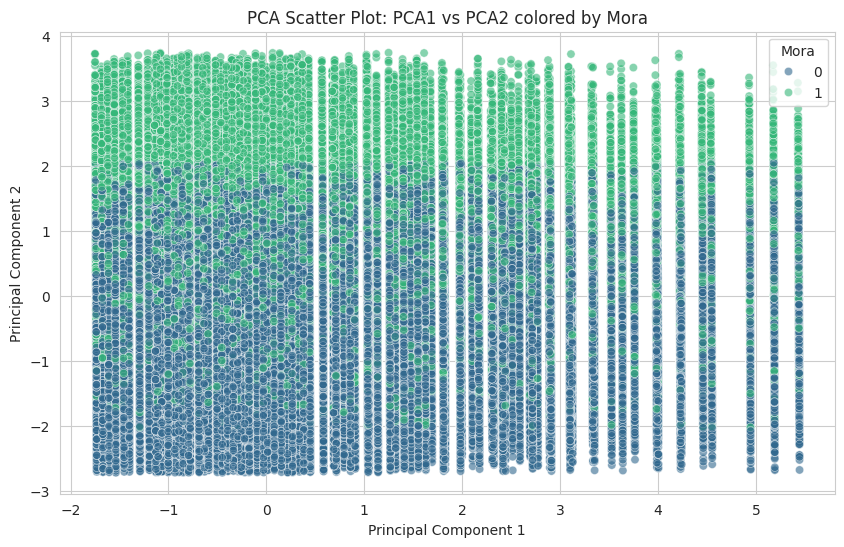

In [9]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='Mora',  # Color the points according to the 'Mora' value (0 or 1)
    data=df_pca,
    palette='viridis', # Optional: change the color palette
    alpha=0.6 # Optional: adjust the transparency of the points
)

plt.title('PCA Scatter Plot: PCA1 vs PCA2 colored by Mora')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


Training set size: 1680000
Test set size: 720000
Proportion of 'Mora' in training set: Mora
0    0.749851
1    0.250149
Name: proportion, dtype: float64
Proportion of 'Mora' in test set: Mora
0    0.74985
1    0.25015
Name: proportion, dtype: float64

--- Model Evaluation ---
Accuracy: 0.7798

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87    539892
           1       0.68      0.23      0.34    180108

    accuracy                           0.78    720000
   macro avg       0.73      0.60      0.60    720000
weighted avg       0.76      0.78      0.74    720000


Confusion Matrix:
[[520444  19448]
 [139075  41033]]


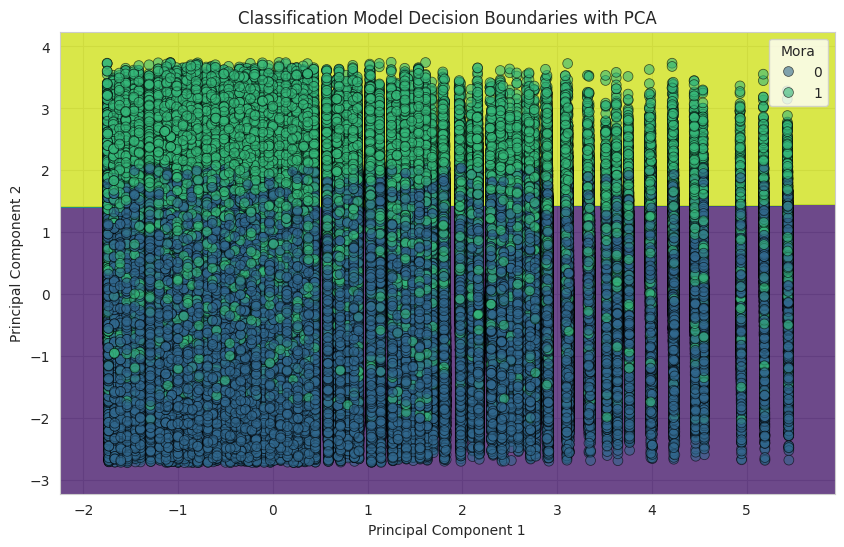

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features (PCA components) and the target variable
X_model = df_pca[['principal_component_1', 'principal_component_2']]
y_model = df_pca['Mora']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42, stratify=y_model) # Stratify to maintain the 'Mora' proportion

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Proportion of 'Mora' in training set: {y_train.value_counts(normalize=True)}")
print(f"Proportion of 'Mora' in test set: {y_test.value_counts(normalize=True)}")

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("\n--- Model Evaluation ---")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: Visualize the decision boundaries (only works well for 2 components)
# You can run this part to see how the model separates the classes in the PCA space.

# Create a grid to plot the decision boundaries
x_min, x_max = X_model['principal_component_1'].min() - 0.5, X_model['principal_component_1'].max() + 0.5
y_min, y_max = X_model['principal_component_2'].min() - 0.5, X_model['principal_component_2'].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict the class for each point in the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and data points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis') # Background colors for the regions

sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='Mora',
    data=df_pca,
    palette='viridis',
    alpha=0.6,
    edgecolor='k', # Add border to points for better visibility
    s=50 # Adjust point size
)

plt.title('Classification Model Decision Boundaries with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(True)
plt.show()



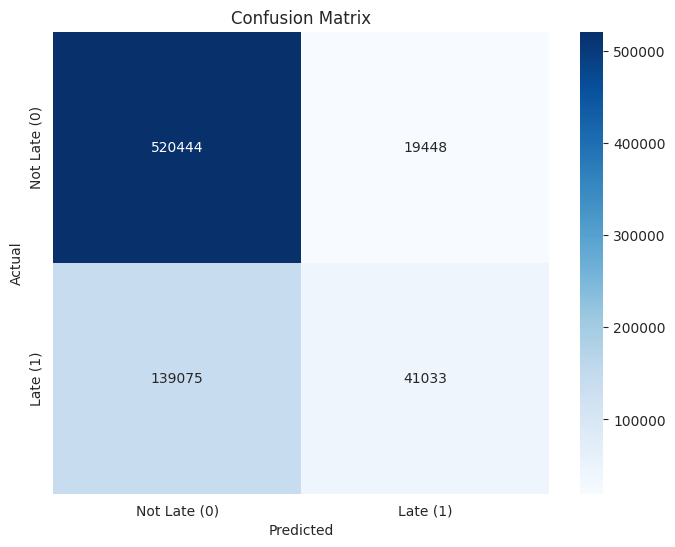


--- Explanation of the Confusion Matrix ---
The confusion matrix shows the performance of our model on the test set.
The rows represent the actual classes (Actual), and the columns represent the predicted classes (Predicted).
We have 4 main cells:
  - Top-left (True Negatives, TN): 520444 cases where the actual value was 0 (Not Late) and the model predicted 0 (Not Late).
  - Top-right (False Positives, FP): 19448 cases where the actual value was 0 (Not Late) but the model predicted 1 (Late). These are 'Type I' errors.
  - Bottom-left (False Negatives, FN): 139075 cases where the actual value was 1 (Late) but the model predicted 0 (Not Late). These are 'Type II' errors.
  - Bottom-right (True Positives, TP): 41033 cases where the actual value was 1 (Late) and the model predicted 1 (Late).

From these values, metrics are calculated such as:
  - Accuracy = (TN + TP) / Total cases = (520444 + 41033) / 720000 = 0.7798
  - Precision (for class 1, Late) = TP / (TP + FP) = 41033 / (41033 + 19

In [11]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Late (0)', 'Late (1)'],
            yticklabels=['Not Late (0)', 'Late (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Explanation of the Confusion Matrix
print("\n--- Explanation of the Confusion Matrix ---")
print(f"The confusion matrix shows the performance of our model on the test set.")
print(f"The rows represent the actual classes (Actual), and the columns represent the predicted classes (Predicted).")
print(f"We have 4 main cells:")
print(f"  - Top-left (True Negatives, TN): {cm[0, 0]} cases where the actual value was 0 (Not Late) and the model predicted 0 (Not Late).")
print(f"  - Top-right (False Positives, FP): {cm[0, 1]} cases where the actual value was 0 (Not Late) but the model predicted 1 (Late). These are 'Type I' errors.")
print(f"  - Bottom-left (False Negatives, FN): {cm[1, 0]} cases where the actual value was 1 (Late) but the model predicted 0 (Not Late). These are 'Type II' errors.")
print(f"  - Bottom-right (True Positives, TP): {cm[1, 1]} cases where the actual value was 1 (Late) and the model predicted 1 (Late).")

print(f"\nFrom these values, metrics are calculated such as:")
print(f"  - Accuracy = (TN + TP) / Total cases = ({cm[0, 0]} + {cm[1, 1]}) / {np.sum(cm):.0f} = {accuracy:.4f}")
print(f"  - Precision (for class 1, Late) = TP / (TP + FP) = {cm[1, 1]} / ({cm[1, 1]} + {cm[0, 1]}): Proportion of positive predictions (Late) that were correct.")
print(f"  - Recall (Sensitivity, for class 1, Late) = TP / (TP + FN) = {cm[1, 1]} / ({cm[1, 1]} + {cm[1, 0]}): Proportion of actual positive cases (Late) that were correctly identified.")
print(f"  - F1-Score (for class 1, Late): Harmonic mean of Precision and Recall, useful when there is a class imbalance.")
print(f"These metrics, especially Precision and Recall, give us a more detailed view of the model's performance, particularly in identifying cases of 'Mora', which may be the class of primary interest.")
